In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta  # For technical indicators
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries installed and imported successfully!")


Libraries installed and imported successfully!


In [2]:
# set up API key here: https://www.alphavantage.co/support/#api-key

# Alpha Vantage API key (Replace with your key)
API_KEY = "818L0AZVDJ6XCXX7"

# Initialize Alpha Vantage TimeSeries API
ts = TimeSeries(key=API_KEY, output_format="pandas")

# Fetch 1-hour intraday data for SPY
# Change 'interval' to '1min' if you want minute-level data
symbol = "SPY"  # S&P 500 ETF
interval = "60min"  # Change to "1min" for minute data

# Get data from Alpha Vantage
df, meta_data = ts.get_intraday(symbol=symbol, interval=interval, outputsize="full")

# Rename columns for easier handling
df.columns = ["Open", "High", "Low", "Close", "Volume"]

# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Sort by time (oldest to newest)
df = df.sort_index()

# Display the first few rows
print(df.head())


                       Open    High     Low    Close    Volume
date                                                          
2025-04-23 04:00:00  536.63  538.80  535.22  537.890  139288.0
2025-04-23 05:00:00  537.94  538.52  537.19  538.010  158516.0
2025-04-23 06:00:00  538.05  540.49  537.96  540.170  246399.0
2025-04-23 07:00:00  540.12  540.72  538.55  538.570  535677.0
2025-04-23 08:00:00  540.17  541.06  519.78  540.945  716129.0


Next, we create technical features. 

- Lagged Returns: Helps capture short-term price trends.
- Exponential Moving Averages (EMA): Detects momentum and trends.
- Relative Strength Index (RSI): Measures overbought/oversold conditions.
- Moving Average Convergence Divergence (MACD): Measures trend direction and strength.
- On-Balance Volume (OBV): Helps track accumulation and distribution of volume.
- Bollinger Bands: Detects volatility and trend reversals.

In [3]:
# Compute Lagged Returns
df["Return"] = df["Close"].pct_change()

# Compute Exponential Moving Averages (EMA)
df["EMA_5"] = df["Close"].ewm(span=5, adjust=False).mean()
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()

# Compute Relative Strength Index (RSI)
df["RSI_14"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()

# Compute MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(df["Close"])
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()

# Compute On-Balance Volume (OBV)
df["OBV"] = ta.volume.OnBalanceVolumeIndicator(df["Close"], df["Volume"]).on_balance_volume()

# Compute Bollinger Bands
bb = ta.volatility.BollingerBands(df["Close"], window=20, window_dev=2)
df["BB_High"] = bb.bollinger_hband()
df["BB_Low"] = bb.bollinger_lband()

# Drop NaN values caused by indicator calculations
df = df.dropna()

# Display first few rows
print(df.head())


                       Open    High     Low   Close     Volume    Return  \
date                                                                       
2025-04-24 20:00:00  546.69  546.69  546.69  546.69  2453880.0 -0.003100   
2025-04-25 04:00:00  549.00  550.08  548.39  548.76    69507.0  0.003786   
2025-04-25 05:00:00  548.84  549.09  547.62  548.68    69493.0 -0.000146   
2025-04-25 06:00:00  548.68  549.30  544.33  544.82   354241.0 -0.007035   
2025-04-25 07:00:00  544.62  546.76  544.40  545.50   418235.0  0.001248   

                          EMA_5      EMA_10     RSI_14      MACD  MACD_Signal  \
date                                                                            
2025-04-24 20:00:00  547.319686  545.893121  61.820339  2.769620     2.219117   
2025-04-25 04:00:00  547.799790  546.414372  65.724653  2.841489     2.343591   
2025-04-25 05:00:00  548.093194  546.826304  65.446105  2.859033     2.446679   
2025-04-25 06:00:00  547.002129  546.461521  53.634726  2.5322

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define feature columns (technical indicators)
feature_columns = [
    "Return", "EMA_5", "EMA_10", "RSI_14", "MACD", "MACD_Signal", "OBV", "BB_High", "BB_Low"
]

# Define the target variable (Next return direction: 1 = Up, 0 = Down)
df["Target"] = (df["Return"].shift(-1) > 0).astype(int)

# Drop last row (since shift creates NaN in the last row)
df = df.dropna()

# Define X (features) and y (target)
X = df[feature_columns].values
y = df["Target"].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into Train (80%) and Test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Reshape for LSTM input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Print dataset shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (272, 9, 1)
X_test shape: (69, 9, 1)
y_train shape: (272,)
y_test shape: (69,)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # LSTM layer
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(50, return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(25, activation="relu"),  # Dense layer
    Dense(1, activation="sigmoid")  # Output layer (binary classification)
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Print model summary
model.summary()


Epoch 1/20


/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4893 - loss: 0.6936 - val_accuracy: 0.6071 - val_loss: 0.6889
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5792 - loss: 0.6917 - val_accuracy: 0.5357 - val_loss: 0.6918
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4852 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5314 - loss: 0.6915 - val_accuracy: 0.5357 - val_loss: 0.6916
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5086 - loss: 0.6937 - val_accuracy: 0.6071 - val_loss: 0.6916
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5701 - loss: 0.6899 - val_accuracy: 0.6071 - val_loss: 0.6913
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4865 - loss: 0.6931 - val_accuracy: 0.6071 - val_loss: 0.6889
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5209 - loss: 0.6902 - val_accuracy: 0.5714 - val_loss: 0.6895
Epoch 9/20
8/8

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 9, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Test Accuracy: 0.4058

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.20      0.25        35
           1       0.43      0.62      0.51        34

    accuracy                           0.41        69
   macro avg       0.39      0.41      0.38        69
weighted avg       0.39      0.41      0.38        69



<module 'matplotlib.pyplot' from '/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/matplotlib/pyplot.py'>

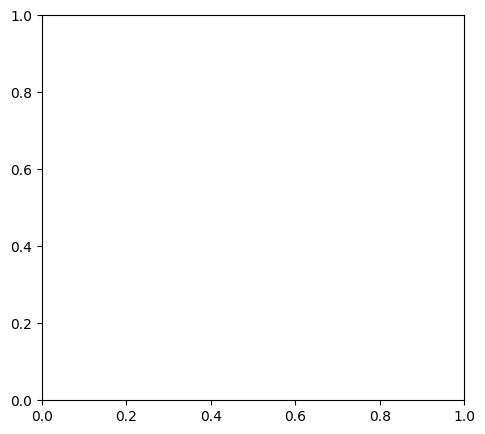

In [6]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

# Evaluate classification accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot training loss & accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt


In [7]:
# Check class distribution
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training Class Distribution: {dict(zip(unique, counts))}")

# Balance the dataset (Undersampling majority class)
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train_balanced, y_train_balanced = rus.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape back for LSTM input
X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], X_train.shape[1], 1)

# Train again with balanced dataset
history = model.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate again
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nUpdated Classification Report:\n", classification_report(y_test, y_pred))


Training Class Distribution: {np.int64(0): np.int64(131), np.int64(1): np.int64(141)}
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5222 - loss: 0.6943 - val_accuracy: 0.3333 - val_loss: 0.7280
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5504 - loss: 0.6864 - val_accuracy: 0.0741 - val_loss: 0.8282
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5624 - loss: 0.6812 - val_accuracy: 0.0000e+00 - val_loss: 0.8898
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5754 - loss: 0.6718 - val_accuracy: 0.1481 - val_loss: 0.8069
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5447 - loss: 0.6957 - val_accuracy: 0.1852 - val_loss: 0.7725
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5695 - loss: 0.6745 - val_accuracy: 0.0370 - val_loss: 0.8673
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5221 - loss: 0.6907 - val_accuracy: 0.1111 - val_loss: 0.8041
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [8]:
# Compute VWAP (Volume Weighted Average Price)
df["VWAP"] = (df["Close"] * df["Volume"]).cumsum() / df["Volume"].cumsum()

# Compute ADX (Average Directional Index)
df["ADX"] = ta.trend.ADXIndicator(df["High"], df["Low"], df["Close"], window=14).adx()

# Add more lagged returns (short-term memory)
for i in range(1, 4):
    df[f"Return_Lag_{i}"] = df["Return"].shift(i)

# Drop NaNs caused by lagging
df = df.dropna()

# Update feature list
feature_columns.extend(["VWAP", "ADX", "Return_Lag_1", "Return_Lag_2", "Return_Lag_3"])

# Redefine X and y
X = df[feature_columns].values
y = df["Target"].values


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

# Define an improved LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),  
    BatchNormalization(),  # Normalize activations
    Dropout(0.3),  

    LSTM(100, return_sequences=False),  
    BatchNormalization(),  
    Dropout(0.3),

    Dense(50, activation="relu"),  
    Dense(1, activation="sigmoid")  # Binary classification (Buy/Sell)
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# Print model summary
model.summary()


Epoch 1/30


/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4357 - loss: 1.0023 - val_accuracy: 0.3929 - val_loss: 0.7001
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5127 - loss: 0.7566 - val_accuracy: 0.3929 - val_loss: 0.7016
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4899 - loss: 0.7509 - val_accuracy: 0.3929 - val_loss: 0.7046
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5333 - loss: 0.7315 - val_accuracy: 0.3929 - val_loss: 0.7036
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5142 - loss: 0.7113 - val_accuracy: 0.3929 - val_loss: 0.7075
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5150 - loss: 0.7027 - val_accuracy: 0.3929 - val_loss: 0.6986
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4995 - loss: 0.7821 - val_accuracy: 0.3929 - val_loss: 0.6991
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4865 - loss: 0.7217 - val_accuracy: 0.3929 - val_loss: 0.7010
Epoch 9/30


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 9, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 9, 100)         │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,505 (1.45 MB)

 Trainable params: 126,701 (494.93 KB)

 Non-trainable params: 400 (1.56 KB)

 Optimizer params: 253,404 (989.86 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Test Accuracy: 0.5507

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.43      0.49        35
           1       0.53      0.68      0.60        34

    accuracy                           0.55        69
   macro avg       0.56      0.55      0.54        69
weighted avg       0.56      0.55      0.54        69



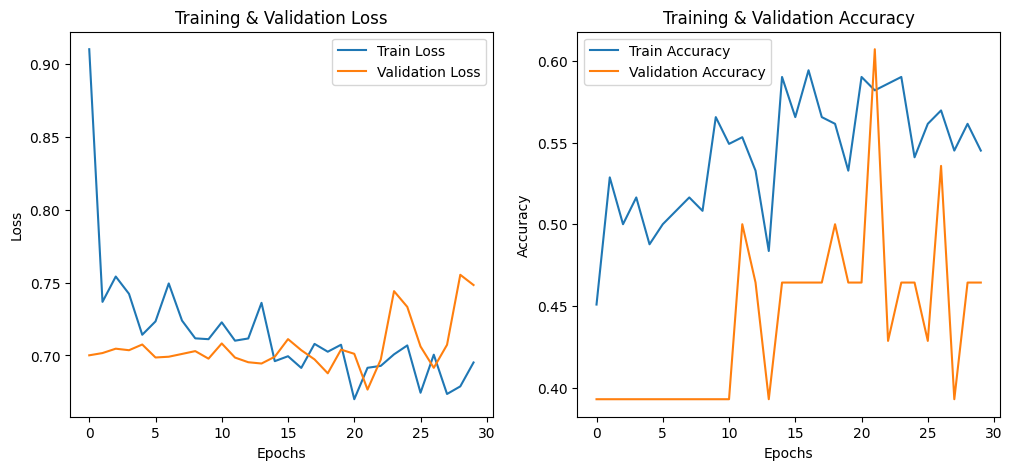

In [10]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot training loss & accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
